# CT Image Segmentation - by Jacqueline Berger

## March 2023

## Load packages

In [1]:
!pip install pydicom

In [2]:
import numpy as np
import pydicom as dicom
import matplotlib.pyplot as plt
import os
import skimage

from pathlib import Path

%matplotlib inline

C:\Users\m0335\anaconda3\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


## The Data

The data consist of sets of DICOM images that hold completely anonymized chest CT scans. DICOM (Digital Imaging and Communications in Medicine) is a standardized format for transmitting medical image data. Each DICOM file is composed of two parts: the image data as well as a header giving you a lot of metadata about the patient and specifics about the imaging parameters (e.g. space between slices).

In [17]:
path = os.path.dirname(os.path.realpath('CT Image Segmentation.ipynb'))
path

'C:\\Users\\m0335\\Documents\\_Selfstudy\\git_projects\\computer_vision'

In [18]:
os.listdir()

['.ipynb_checkpoints',
 'CT Image Segmentation.ipynb',
 'LungCT-Diagnostic Pre-Surgery Contrast Enhanced']

In [19]:
scans = os.listdir(path + '\\LungCT-Diagnostic Pre-Surgery Contrast Enhanced\\')
scans

['R_006',
 'R_020',
 'R_029',
 'R_043',
 'R_064',
 'R_066',
 'R_069',
 'R_075',
 'R_210',
 'R_274']

## DICOM

The dicom file consist of 2 parts, metadata and a pixel array. docim from the pydicom package allows us to read in the data

In [24]:
#reading one dicom file
ds = dicom.read_file(path + '\\LungCT-Diagnostic Pre-Surgery Contrast Enhanced\\R_006\\0b553937-d616-4749-9f2a-d999fe912046.dcm')
#ds

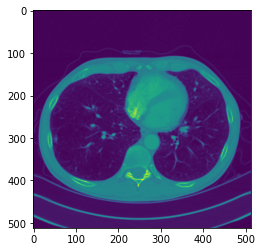

In [25]:
#loading the dicom pixels array(which representas the image)
rawimg = ds.pixel_array
plt.imshow(rawimg, cmap='viridis')
plt.show()

In [27]:
#the raw pixels are represented in 16 bit integer format
rawimg.dtype

dtype('uint16')

# Data pre-processing

## 1.Hounsfield conversion

Some important DICOM fields like $RescaleIntercept$ and $RescaleSlope$ determine how the image pixel values should be interpreted. These metadata are critical for quantitative imaging methods like CT. The default raw pixel values are arbitrary units returned from the actual machine used and may differ based on the scanner manufacturer. 

The conversion formula is:

$$ \textrm{Hounsfield Units} = RescaleSlope \times \textrm{Raw Image} + RescaleIntercept $$

In [29]:
def get_slice_path(scan_path: str, scan_num: int, slice_num: int):
    
    list_of_scans = os.listdir(scans_path)
    scan_path = os.path.join(scans_path, list_of_scans[scan_num])
    list_of_slices = os.listdir(scan_path)
    
    return os.path.join(scan_path, list_of_slices[slice_num])

def get_slice(slice_path: str):
    
    return dicom.read_file(slice_path)

In [38]:
#Fetch an arbitrary scan image
slice_path = get_slice_path(path + '\\LungCT-Diagnostic Pre-Surgery Contrast Enhanced\\',2,42)
slice_object = get_slice(slice_path)

#slice_object

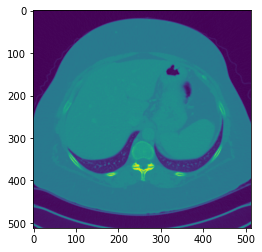

In [39]:
def hounsfield_conversion(slice_object):
    
    raw_img = slice_object.pixel_array
    slope = slice_object.RescaleSlope
    intercept = slice_object.RescaleIntercept

    hounsfield_img = (slope * raw_img) + intercept
    return hounsfield_img

#print(slice_object.pixel_array.dtype) #uint16
houns_img = hounsfield_conversion(slice_object)

#print(houns_img.dtype) float64

plt.imshow(houns_img, cmap='viridis')
plt.show()

######################################################################################################

## 2.Merging 2D files into 3D

Merge of all the individual 2D slices of the CT scan (each one stored as a .dcm file) into a 3D volume. The 2D images need to be sorted as per slice_object.SliceLocation parameter.

In [43]:
def order_houns_slices(single_scans_slices):
    #orders slices as per SLiceLocation and performs hounsfield conversion on each slice
    #returns volume with hounsfield conversion applied
    vol = [(0,0)] * len(single_scans_slices)           
    for i in range(len(single_scans_slices)):
        vol[i] = (get_slice(scans_path + "\\" + select_scan + "\\" + single_scans_slices[i]) , 
              get_slice(scans_path + "\\" + select_scan + "\\" + single_scans_slices[i]).SliceLocation)
    
    #houns_img = hounsfield_conversion(slice_object)

    vol = list(sorted(vol, key = lambda x: x[1]))            
    vol = np.dstack([hounsfield_conversion(x[0]) for x  in vol])
    return vol

In [45]:
#select here which scan you want to have from the list above
select_scan = 'R_006'

single_scans_slices = os.listdir(path + "\\LungCT-Diagnostic Pre-Surgery Contrast Enhanced\\" + select_scan)
print(len(single_scans_slices), ' slices are present in scan: ', select_scan)

vol = order_houns_slices(single_scans_slices)
print('volume shape is: ', vol.shape, 'volume type is: ', vol.dtype)

130  slices are present in scan:  R_006
volume shape is:  (512, 512, 130) volume type is:  float64


## normalizing the pixel array 

In [47]:
# The numbers are stored in int16 so from -32768 to 32767
print('dtype before: ', vol[0].dtype, 'min: ',np.min(vol),'max: ', np.max(vol))

#conversion from int16 to float32
vol_32 = vol.astype('float32')

print('dtype before: ', vol_32[0].dtype, 'min: ',np.min(vol_32),'max: ', np.max(vol_32))

vol_32_norm = (vol_32-np.min(vol_32))/((np.max(vol_32)-np.min(vol_32)))
print('dtype after normalization: ', vol_32_norm[0].dtype, 'min: ', np.min(vol_32_norm), 'max: ', np.max(vol_32_norm))
vol_32_norm.shape

dtype before:  float64 min:  -1024.0 max:  3071.0
dtype before:  float32 min:  -1024.0 max:  3071.0
dtype after normalization:  float32 min:  0.0 max:  1.0


(512, 512, 130)

## scan visualization

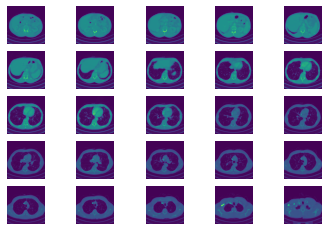

In [46]:
fig,ax = plt.subplots(5,5)
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(vol[:,:,(i*5+j)*5], cmap = 'viridis')
        ax[i,j].axis('off')
plt.rcParams['figure.figsize']=(30, 18)

## OTSU threshold

We see a 3D matrix of lung CT data. Pixel values of CT scans are given in Hounsfield units, where lower Hounsfield units correspond to low density materials (like air) that are not highly attenuative for X-rays and higher Hounsfield units correspond to highly attenuative materials, like bone.

Otsu's threshold separates pixels into two classes, foreground and background

### Representing otsu threshold in an histogram

0.13867188


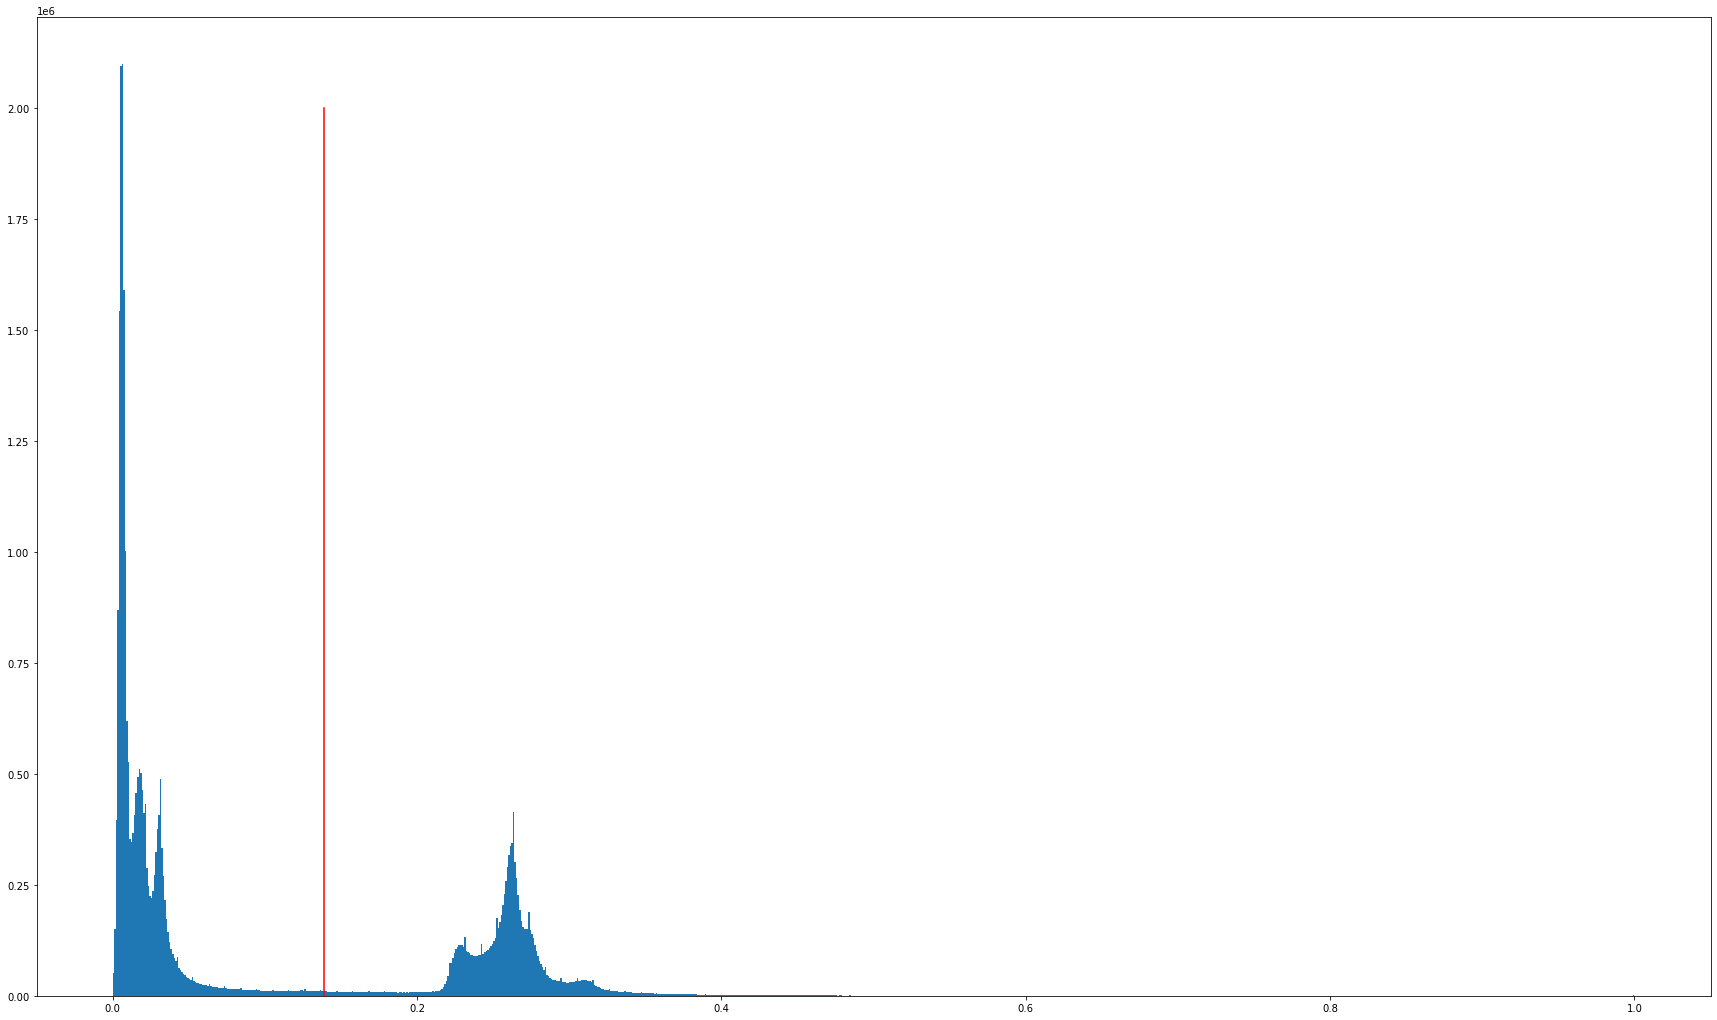

In [48]:
vol = vol_32_norm
vol_hist = np.ravel(vol) #Return a contiguous flattened array.

from skimage.filters import threshold_otsu
thresh = threshold_otsu(vol_hist) #thresh is an integer
print(thresh)

_ = plt.hist(vol_hist.reshape([-1]),1000)
plt.plot([thresh,thresh],[0,2000000],'r')
plt.show()

## highlighting only parts in the plot above the otsu threshold

The numbers above the threshold represent the foreground.

We can see our dark lungs surrounded by lighter-colored tissue, which is then again surrounded by the darkness of the 0-pixels.

0.13867188


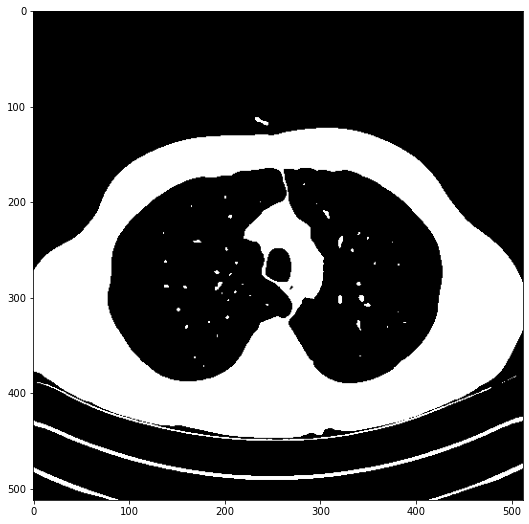

In [53]:
print(thresh) #threshold is between 0 and 1 due to the normalization of the data
plt.imshow(vol[:,:,100] > thresh, cmap = 'gray')
plt.rcParams['figure.figsize'] = (30,9)

## Separation of lungs from background

### applying a binary mask

pixel below threshold become 1s, above becomes 0s.

In [56]:
def generate_binary_mask(vol):
    vol = np.where(vol <= thresh, 1, 0)
    return vol

vol_bw = generate_binary_mask(vol)
#plt.imshow(vol_bw[:,:,100])

each area of connected pixels get a label, different labels are illustrated by different colors. Next we make all labels connected to the border null. Since our lungs are in none of the picture connected to the border they stay unaffected

In [60]:
from skimage.measure import label

def generate_labels(vol):
    for vol_slice in range(vol.shape[2]): 
        vol[:,:,vol_slice] = label(vol[:,:,vol_slice])
    return vol

In [67]:
vol_bw_labeled = generate_labels(vol_bw)
#plt.imshow(vol_bw_labeled[:,:,100], cmap='nipy_spectral')
#plt.rcParams['figure.figsize'] = (60,9)

In [68]:
def get_labels_from_border(labelled_vol_slice):
    '''takes as input a 2D array (vol_sice) and detects the labels defining the borders
    Ideally the array consists of labels after applying the measure.label function
    from skimage
    '''
    up = np.unique(labelled_vol_slice[0,:])
    down = np.unique(labelled_vol_slice[-1,:])
    left = np.unique(labelled_vol_slice[:,0])
    right = np.unique(labelled_vol_slice[:,-1])
    border_labels = np.unique(np.concatenate((left,right,up,down), axis = None))

    return border_labels

In [69]:
def highlight_lungs(vol):
    for vol_slice in range(vol.shape[2]):  
        border_labels = get_labels_from_border(vol[:,:,vol_slice]) #an array of border lables to become Nulled
        #print('borders',border_labels)
        vol[:,:,vol_slice] = np.where(np.isin(vol[:,:,vol_slice], border_labels), 0, 1)
        #print(np.sum(vol[:,:,vol_slice]))
    return vol

vol_lungs = highlight_lungs(vol_bw_labeled)

In [70]:
#plt.imshow(vol_lungs[:,:,100], cmap = 'gray')
#plt.rcParams['figure.figsize'] = (60,9)

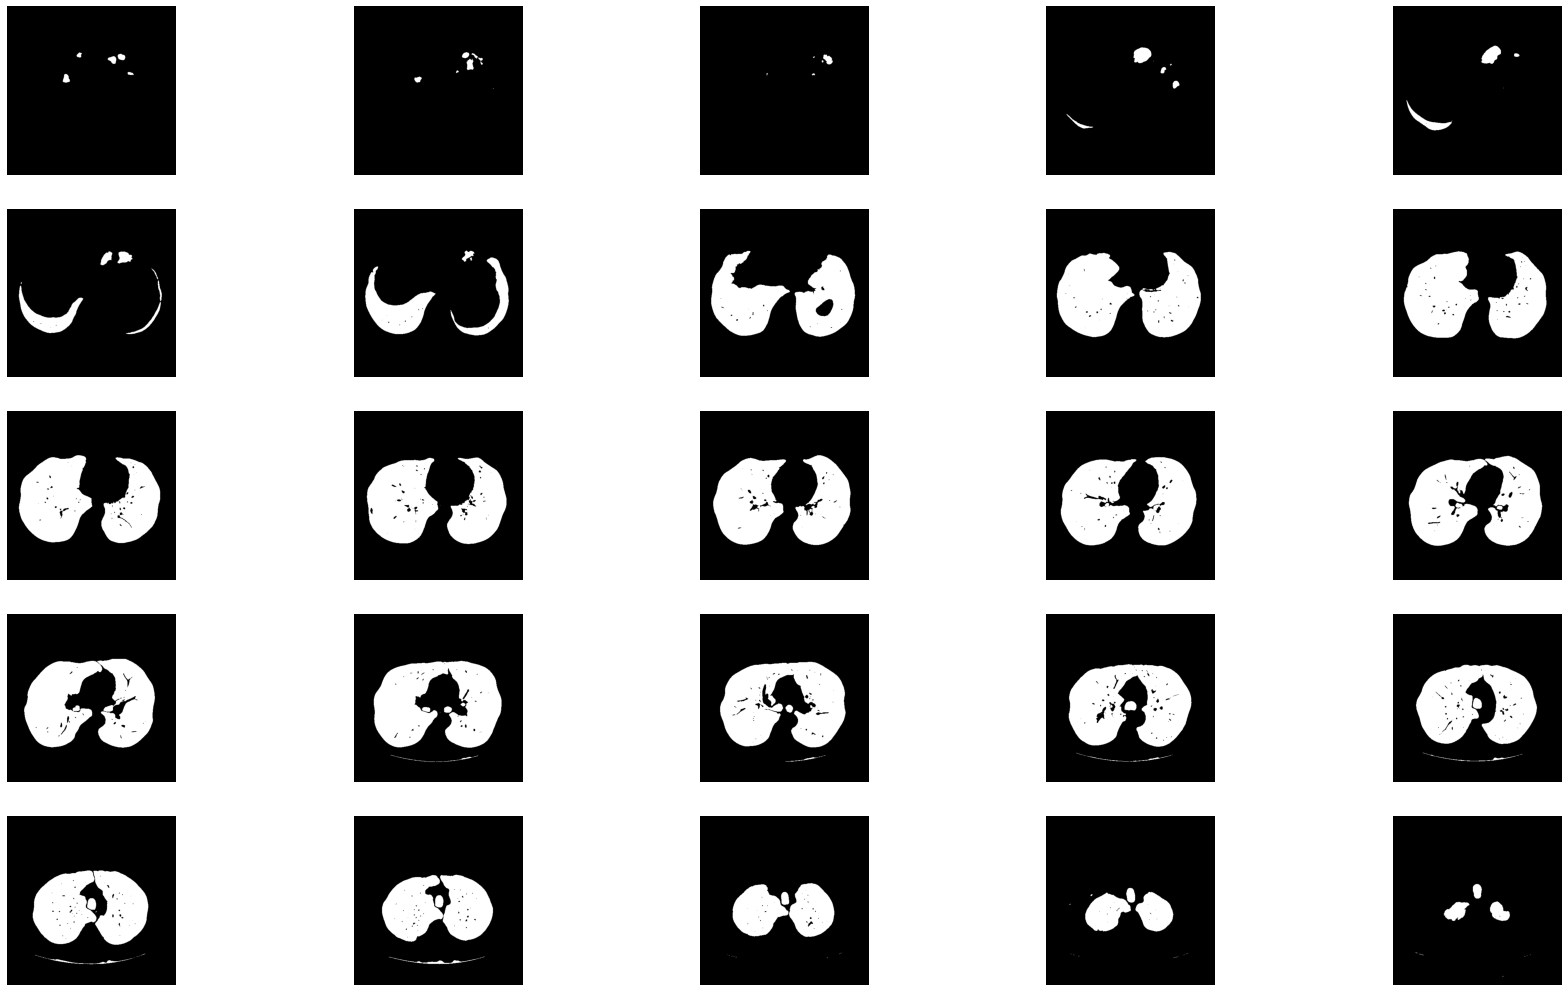

In [72]:
fig,ax = plt.subplots(5,5)
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(vol_lungs[:,:,(i*5+j)*5], cmap = 'gray')
        ax[i,j].axis('off')
#plt.rcParams['figure.figsize']=(30, 18)

# Try out different scans

## scan R_043

0.13085938


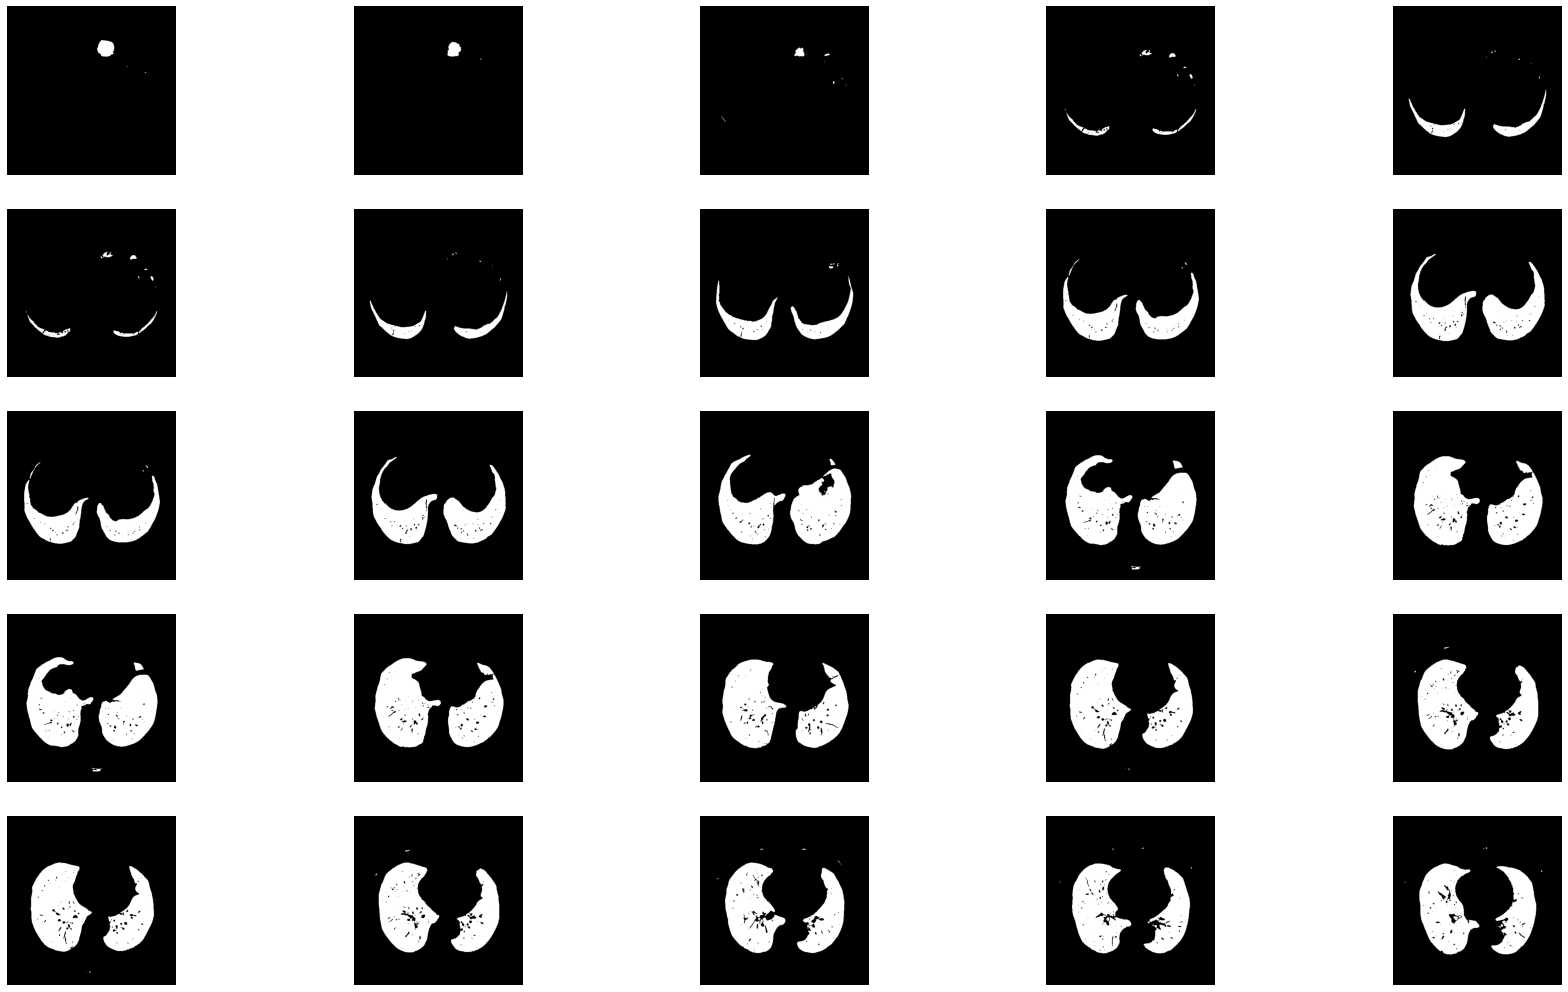

In [73]:
#['R_006', 'R_020', 'R_029', 'R_043', 'R_064', 'R_066', 'R_069', 'R_075', 'R_210', 'R_274']
select_scan = 'R_043'
single_scans_slices = os.listdir("C:\\Users\\m0335\\Documents\\6S\\Image Processing and Visual Computing in Biology and Medicine\\LungCT-Exercise 1 data\\LungCT-Diagnostic Pre-Surgery Contrast Enhanced\\"+select_scan)
intervals = int(len(single_scans_slices)/25 -1)

#order slices and convert to hounsfield units
vol = order_houns_slices(single_scans_slices)

#change type and normalize the pixels
vol_32 = vol.astype('float32')
vol_32_norm = (vol_32-np.min(vol_32))/((np.max(vol_32)-np.min(vol_32)))

#calculate otsu threshold
thresh = threshold_otsu(np.ravel(vol_32_norm))
print(thresh)

#replace values below threshold with 0s, the rest becomes 1
vol_bw = generate_binary_mask(vol_32_norm)

#generate labels
vol_bw_labeled = generate_labels(vol_bw)

#highlight lungs only
vol_lungs = highlight_lungs(vol_bw_labeled)

#generate plots
fig,ax = plt.subplots(5,5)
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(vol_bw[:,:,(i*intervals+j)*intervals], cmap = 'gray')
        ax[i,j].axis('off')
plt.rcParams['figure.figsize']=(30, 18)

## scan R_210

0.13476562


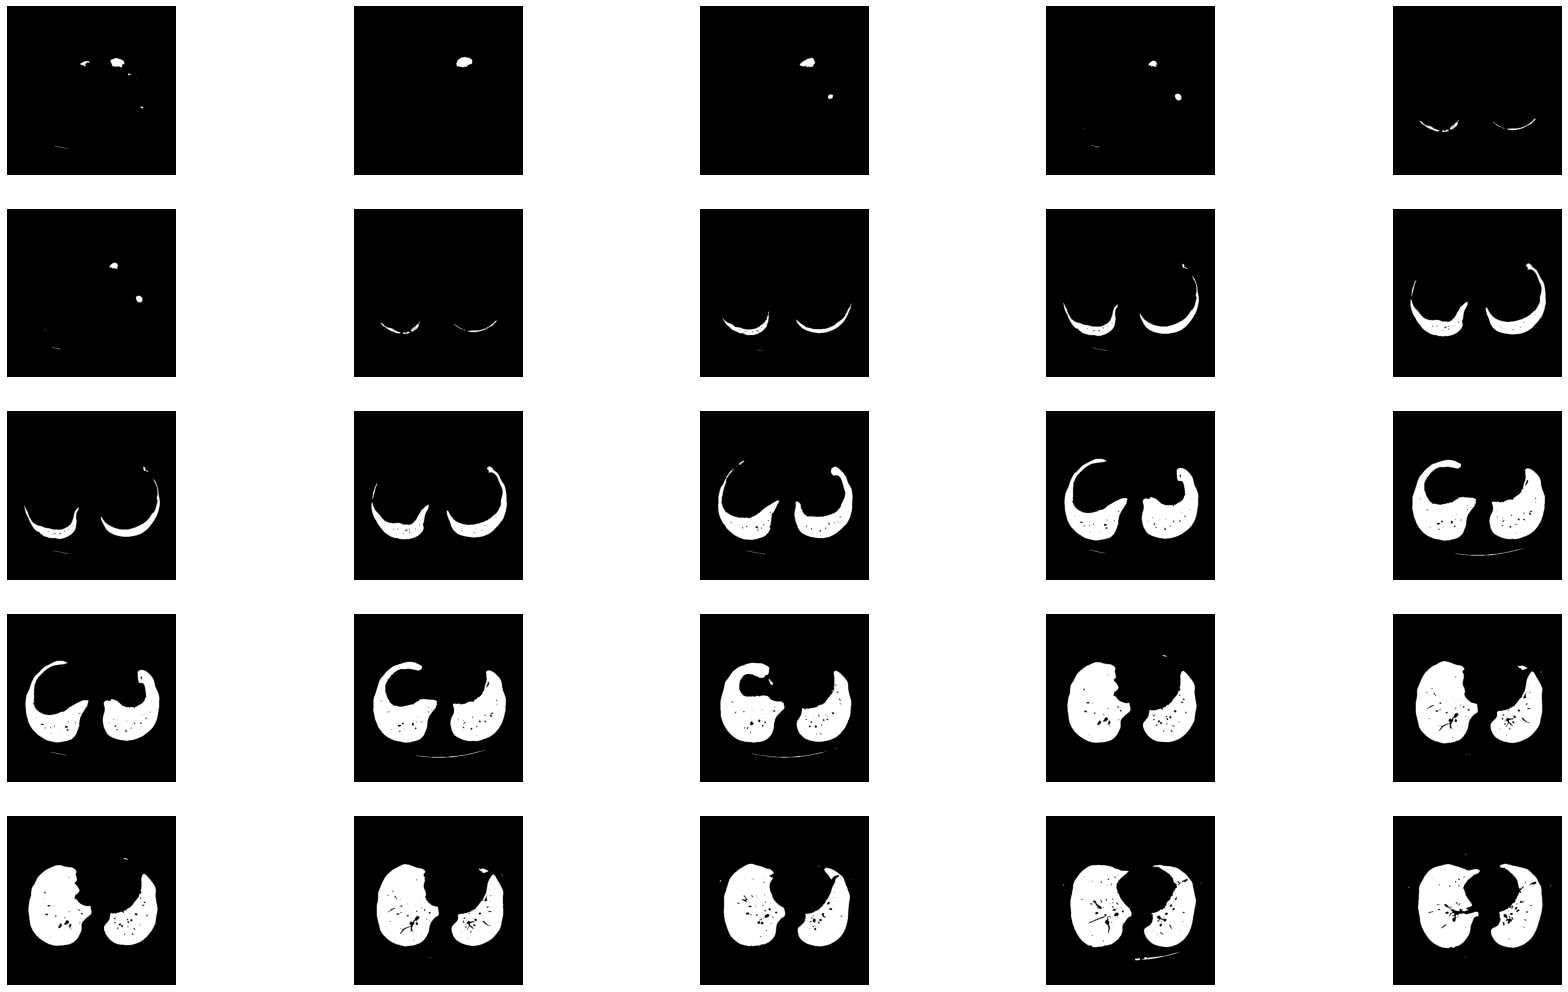

In [74]:
#['R_006', 'R_020', 'R_029', 'R_043', 'R_064', 'R_066', 'R_069', 'R_075', 'R_210', 'R_274']
select_scan = 'R_210'
single_scans_slices = os.listdir("C:\\Users\\m0335\\Documents\\6S\\Image Processing and Visual Computing in Biology and Medicine\\LungCT-Exercise 1 data\\LungCT-Diagnostic Pre-Surgery Contrast Enhanced\\"+select_scan)
intervals = int(len(single_scans_slices)/25 -1)

#order slices and convert to hounsfield units
vol = order_houns_slices(single_scans_slices)

#change type and normalize the pixels
vol_32 = vol.astype('float32')
vol_32_norm = (vol_32-np.min(vol_32))/((np.max(vol_32)-np.min(vol_32)))

#calculate otsu threshold
thresh = threshold_otsu(np.ravel(vol_32_norm))
print(thresh)

#replace values below threshold with 0s, the rest becomes 1
vol_bw = generate_binary_mask(vol_32_norm)

#generate labels
vol_bw_labeled = generate_labels(vol_bw)

#highlight lungs only
vol_lungs = highlight_lungs(vol_bw_labeled)

#generate plots
fig,ax = plt.subplots(5,5)
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(vol_bw[:,:,(i*intervals+j)*intervals], cmap = 'gray')
        ax[i,j].axis('off')
plt.rcParams['figure.figsize']=(30, 18)